## Test 2D Benchmarks

In this example we reproduce the 2D examples in Birky et al. 2025

In [1]:
import alabi
import alabi.utility as ut
import alabi.metrics as metrics
import alabi.benchmarks as bm
import alabi.visualization as vis
from alabi.core import SurrogateModel

import numpy as np
import corner
import matplotlib.pyplot as plt
from functools import partial
import scipy.stats as stats
from scipy.stats import multivariate_normal
from sklearn import preprocessing
import pickle
import tqdm

In [2]:
def run_demo(lnlike_fn, bounds, savedir="results", 
             gp_kwargs={"kernel": "ExpSquaredKernel", "fit_amp": True, "fit_mean": True, "white_noise": -12, "gp_opt_method": "l-bfgs-b"},
             al_kwargs={"algorithm": "bape", "gp_opt_freq": 20, "obj_opt_method": "l-bfgs-b", "nopt": 1},
             ninit=50, niter=200):
    
    sm = SurrogateModel(lnlike_fn=lnlike_fn, 
                        bounds=bounds, 
                        savedir=savedir,
                        ncore=10, verbose=False)

    sm.init_samples(ntrain=ninit, ntest=1000, sampler="sobol")
    sm.init_gp(**gp_kwargs)
    sm.active_train(niter=niter, **al_kwargs)
    
    return sm


In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_contour_2D_no_colorbar(fn, ax, bounds, ngrid=60, cmap='Blues_r', vmin=None, vmax=None):
    """Modified version that returns the contour mappable without creating a colorbar"""
    xarr = np.linspace(bounds[0][0], bounds[0][1], ngrid)
    yarr = np.linspace(bounds[1][0], bounds[1][1], ngrid)

    X, Y = np.meshgrid(xarr, yarr)
    Z = np.zeros((ngrid, ngrid))

    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            tt = np.array([X[i][j], Y[i][j]])
            Z[i][j] = fn(tt)
        
    im = ax.contourf(X, Y, Z, 20, cmap=cmap, vmin=vmin, vmax=vmax)
    return im

def plot_two_panel(sm, kernel="ExpSquaredKernel", true_fn_name="True Function", title_size=20, text_size=18, cmap="Blues_r", cb_rng=[None, None], 
                   show_text=False, show_labels=True, figsize=(12, 5), remove_ticks=True):

    theta0 = sm.theta_scaler.inverse_transform(sm._theta0)
    theta = sm.theta()[sm.ninit_train:]
    
    if cb_rng[0] is None:
        cb_rng[0] = sm.y().min()
    if cb_rng[1] is None:
        cb_rng[1] = sm.y().max()
    
    # Create figure with GridSpec for precise control
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.09], wspace=0.05)
    
    # Create the two main axes with equal sizes
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    axs = [ax1, ax2]
    
    # Set equal aspect ratio for both axes
    for ax in axs:
        ax.set_aspect('equal')
        
    # Share x and y limits
    ax2.sharex(ax1)
    ax2.sharey(ax1)

    # Plot contours without individual colorbars
    im1 = plot_contour_2D_no_colorbar(fn=sm.true_log_likelihood, ax=axs[0], bounds=sm.bounds, 
                                      vmin=cb_rng[0], vmax=cb_rng[1], cmap=cmap)
    im2 = plot_contour_2D_no_colorbar(fn=sm.surrogate_log_likelihood, ax=axs[1], bounds=sm.bounds, 
                                      vmin=cb_rng[0], vmax=cb_rng[1], cmap=cmap)
    
    # Use make_axes_locatable to create colorbar that matches axis height exactly
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = plt.colorbar(im1, cax=cax)
    cbar.ax.tick_params(labelsize=text_size-2)

    # Add scatter points
    if show_labels:
        axs[1].scatter(theta0[:, 0], theta0[:, 1], s=10, c='limegreen', 
                      label=f"initial: {sm.ninit_train}")
        axs[1].scatter(theta[:, 0], theta[:, 1], s=10, c='r', 
                      label=f"active learning: {sm.ntrain - sm.ninit_train}")
        legend = axs[1].legend(loc="lower left", fontsize=text_size)
        legend.get_texts()[0].set_color('green')
        legend.get_texts()[1].set_color('red')
    else:
        axs[1].scatter(theta0[:, 0], theta0[:, 1], s=10, c='limegreen')
        axs[1].scatter(theta[:, 0], theta[:, 1], s=10, c='r')

    # Set titles
    axs[0].set_title(true_fn_name, fontsize=title_size)
    if kernel == "ExpSquaredKernel":
        axs[1].set_title("Exponential Squared Kernel", fontsize=title_size)
    elif kernel == "Matern32Kernel":
        axs[1].set_title("Matern 3/2 Kernel", fontsize=title_size)
    elif kernel == "Matern52Kernel":
        axs[1].set_title("Matern 5/2 Kernel", fontsize=title_size)
    else:
        axs[1].set_title(f"{kernel}", fontsize=title_size)
        
    if remove_ticks:
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

    # Optional text annotations
    if show_text:
        axs[1].text(1.05, 1, "training samples:", fontsize=text_size, ha='left', va='top', 
                   color="black", transform=axs[1].transAxes)
        axs[1].text(1.05, 0.9, f"initial: {sm.ninit_train}", fontsize=text_size, ha='left', 
                   va='top', color="forestgreen", transform=axs[1].transAxes)
        axs[1].text(1.05, 0.8, f"active learning: {sm.ntrain - sm.ninit_train}", 
                   fontsize=text_size, ha='left', va='top', color="red", 
                   transform=axs[1].transAxes)

    return fig, axs

In [4]:
ninit = 10
niter = 100
basedir = "demo"
kernel = "ExpSquaredKernel"
benchmark = "rosenbrock"
savedir = f"{basedir}/{benchmark}/{kernel}/{ninit}_{niter}"

gp_kwargs = {"kernel": kernel, 
             "fit_amp": True, 
             "fit_mean": True, 
             "fit_white_noise": False, 
             "white_noise": -12,
             "gp_opt_method": "l-bfgs-b",
             "gp_scale_rng": [-2,2],
             "optimizer_kwargs": {"max_iter": 50}}

al_kwargs={"algorithm": "bape", 
           "gp_opt_freq": 20, 
           "obj_opt_method": "nelder-mead", 
           "nopt": 1,
           "optimizer_kwargs": {"max_iter": 50, 'xatol': 1e-3, 'fatol': 1e-3}}

# sm = alabi.load_model_cache(savedir)
    
sm = run_demo(lnlike_fn=bm.rosenbrock["fn"], bounds=bm.rosenbrock["bounds"],
            ninit=ninit, niter=niter, 
            savedir=savedir, al_kwargs=al_kwargs,
            gp_kwargs=gp_kwargs)

Computed 10 function evaluations: 0.0s 

Computed 1000 function evaluations: 0.0s 

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1


100%|██████████| 100/100 [00:09<00:00, 10.17it/s]

Caching model to demo/rosenbrock/ExpSquaredKernel/10_100/surrogate_model...


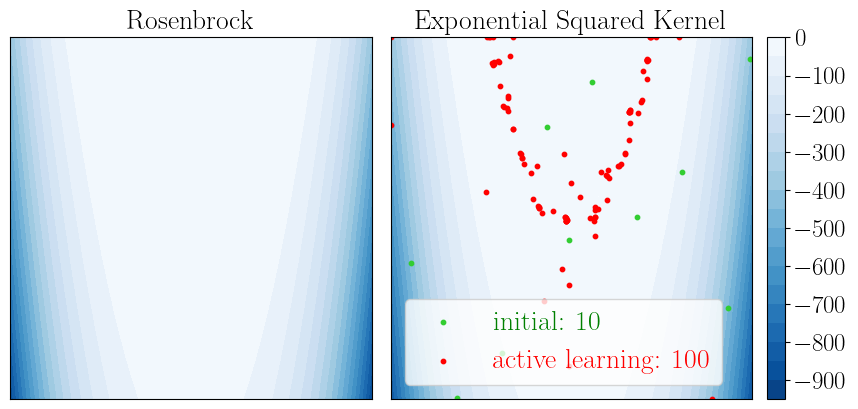

In [5]:
fig, axs = plot_two_panel(sm, true_fn_name="Rosenbrock", title_size=20, text_size=20, cmap="Blues_r", 
                     cb_rng=[-1000, 0], show_labels=True, figsize=[10, 6])
plt.savefig(f"{basedir}/{benchmark}_demo.png", dpi=500, bbox_inches='tight')
plt.show()

In [14]:
ninit = 200
niter = 200
basedir = "demo"
kernel = "Matern52Kernel"
benchmark = "eggbox"
savedir = f"{basedir}/{benchmark}/{kernel}/{ninit}_{niter}"

gp_kwargs = {"kernel": kernel, 
             "fit_amp": True, 
             "fit_mean": True, 
             "fit_white_noise": False, 
             "white_noise": -12,
             "gp_opt_method": "l-bfgs-b",
             "gp_scale_rng": [-2,2],
             "optimizer_kwargs": {"max_iter": 50}}

al_kwargs={"algorithm": "bape", 
           "gp_opt_freq": 20, 
           "obj_opt_method": "nelder-mead", 
           "nopt": 1,  # increase number of optimization attempts since function has many modes
           "optimizer_kwargs": {"max_iter": 50, 'xatol': 1e-3, 'fatol': 1e-3}}
    
sm = run_demo(lnlike_fn=bm.eggbox["fn"], bounds=bm.eggbox["bounds"], 
            ninit=ninit, niter=niter, 
            savedir=savedir, gp_kwargs=gp_kwargs, al_kwargs=al_kwargs)

Computed 200 function evaluations: 0.0s 

Computed 1000 function evaluations: 0.0s 

Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1


100%|██████████| 200/200 [00:41<00:00,  4.87it/s]

Caching model to demo/eggbox/Matern52Kernel/200_200/surrogate_model...


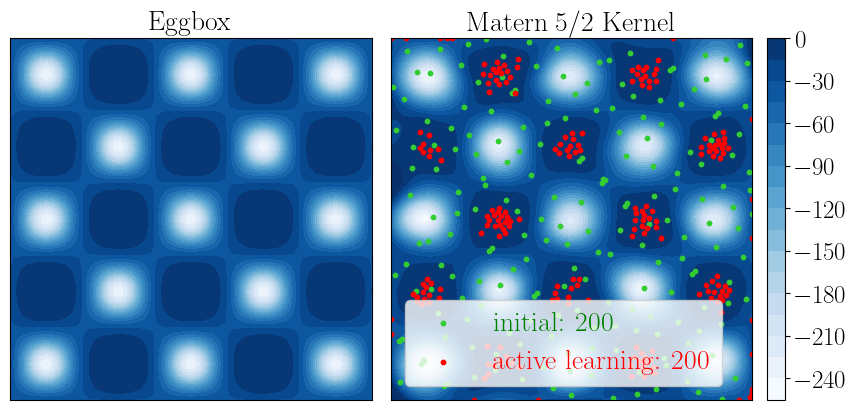

In [15]:
fig = plot_two_panel(sm, title_size=20, text_size=20, cmap="Blues", true_fn_name="Eggbox", kernel=kernel, 
                     cb_rng=[-250, 0], show_labels=True, figsize=[10, 6])
plt.savefig(f"{basedir}/{benchmark}_demo.png", dpi=500, bbox_inches='tight')
plt.show()

In [8]:
ninit = 50
niter = 200
basedir = "demo"
kernel = "Matern52Kernel"
benchmark = "gaussian_shells"
optimizer = "nelder-mead"
savedir = f"{basedir}/{benchmark}/{kernel}/{optimizer}/{ninit}_{niter}"

gp_kwargs = {"kernel": kernel, 
             "fit_amp": True, 
             "fit_mean": True, 
             "fit_white_noise": False, 
             "white_noise": -12,
             "gp_opt_method": "l-bfgs-b",
             "gp_scale_rng": [-2,2],
             "optimizer_kwargs": {"max_iter": 50}}

al_kwargs={"algorithm": "bape", 
           "gp_opt_freq": 20, 
           "obj_opt_method": "nelder-mead", 
           "nopt": 1,
           "optimizer_kwargs": {"max_iter": 50, 'xatol': 1e-3, 'fatol': 1e-3}}

sm = run_demo(lnlike_fn=bm.gaussian_shells["fn"], bounds=bm.gaussian_shells["bounds"],
            ninit=ninit, niter=niter, savedir=savedir, 
            gp_kwargs=gp_kwargs, al_kwargs=al_kwargs)

Computed 50 function evaluations: 0.0s 

Computed 1000 function evaluations: 0.0s 

Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1


100%|██████████| 200/200 [00:27<00:00,  7.31it/s]

Caching model to demo/gaussian_shells/Matern52Kernel/nelder-mead/50_200/surrogate_model...


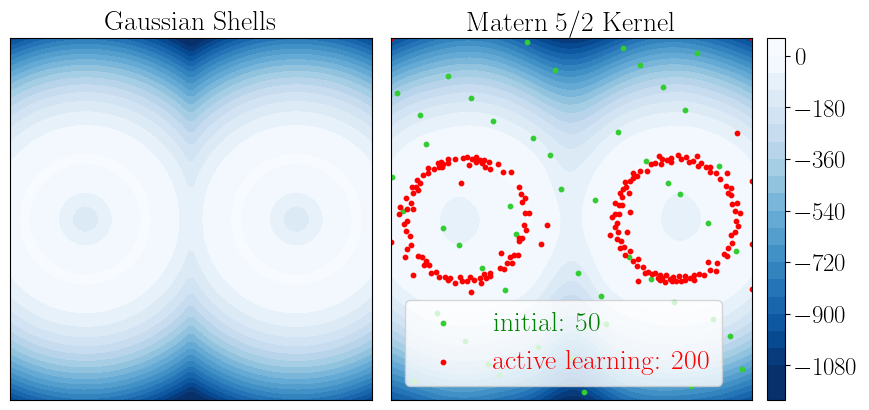

In [9]:
fig = plot_two_panel(sm, title_size=20, text_size=20, cmap="Blues_r", true_fn_name="Gaussian Shells", kernel=kernel,
                     cb_rng=[-1100,0], show_labels=True, figsize=[10, 6])
plt.savefig(f"{basedir}/{benchmark}_demo.png", dpi=500, bbox_inches='tight')
plt.show()

In [10]:
ninit = 10
niter = 100
basedir = "demo"
kernel = "ExpSquaredKernel"
benchmark = "gaussian_2d"
savedir = f"{basedir}/{benchmark}/{kernel}/{ninit}_{niter}"

gp_kwargs = {"kernel": kernel, 
             "fit_amp": True, 
             "fit_mean": True, 
             "fit_white_noise": False, 
             "white_noise": -12,
             "gp_opt_method": "l-bfgs-b",
             "gp_scale_rng": [-2,2],
             "optimizer_kwargs": {"max_iter": 50}}

al_kwargs={"algorithm": "bape", 
           "gp_opt_freq": 20, 
           "obj_opt_method": "nelder-mead", 
           "nopt": 1,
           "optimizer_kwargs": {"max_iter": 50, 'xatol': 1e-3, 'fatol': 1e-3}}

# Define 2D normal likelihood function
mean = np.zeros(2)  # Mean vector for 2D Gaussian
cov = np.array([[0.2, -0.1], [-0.1, 0.1]])
lnlike = partial(multivariate_normal.logpdf, mean=mean, cov=cov)

sm = run_demo(lnlike_fn=lnlike, bounds=[[-5, 5], [-5, 5]],
            ninit=ninit, niter=niter, savedir=savedir, gp_kwargs=gp_kwargs, al_kwargs=al_kwargs)

Computed 10 function evaluations: 0.0s 

Computed 1000 function evaluations: 0.0s 

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Caching model to demo/gaussian_2d/ExpSquaredKernel/10_100/surrogate_model...


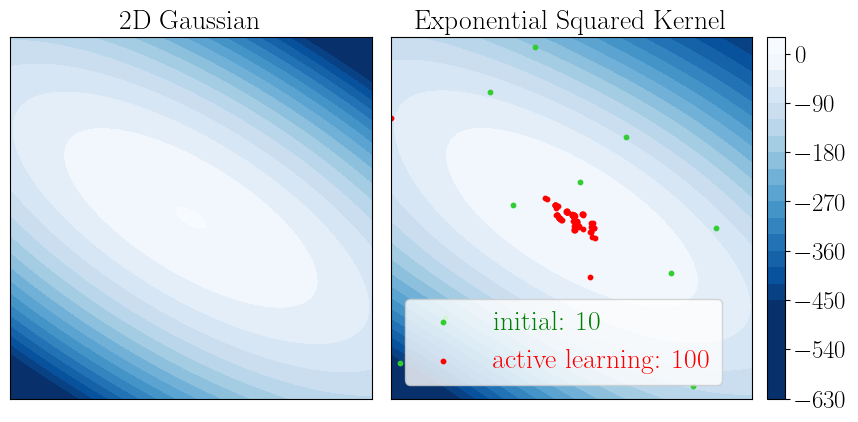

In [11]:
fig = plot_two_panel(sm, title_size=20, text_size=20, cmap="Blues_r", true_fn_name="2D Gaussian", kernel=kernel,
                     show_labels=True, figsize=[10, 6])
plt.savefig(f"{basedir}/{benchmark}_demo.png", dpi=500, bbox_inches='tight')
plt.show()